In [2]:
import numpy as np
import abc
import os, sys
import hashlib
from os.path import join as opj

import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.rcParams.update({'font.size': 18})
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import healpy as hp

import plancklens
from plancklens import utils

from lenscarf.iterators.statics import rec

from component_separation.cs_util import Config

from lenscarf.lerepi.visalot import plot_helper as ph
from lenscarf.lerepi.visalot.plot_helper import colorscale, bandpass_alms, get_ms

csu = Config('Planck')
colors = csu.CB_color_cycle
colors_lt = csu.CB_color_cycle_lighter

nside = 2048
lmax_cl = 2048
lmax_plot = 195
lmax_qlm = 2500
lmax_mask = 4096

bk14_edges = np.array([2,55,90,125,160,195,230,265,300, 500, 700, 1000, 1500, 2000, 3000, 4000, 5000]) # BK14 is [ 55  90 125 160 195 230 265 300], from bk14 = h5py.File('/global/homes/s/sebibel/notebooks/CMBS4/datasharing/likedata_BK14.mat', 'r')['likedata']['lval'][0,:]
ioreco_edges = np.array([2,30,200, 300, 500, 700, 1000, 1500, 2000, 3000, 4000, 5000])
cmbs4_edges = np.array([2, 30, 60, 90, 120, 150, 180, 200, 300, 500, 700, 1000, 1500, 2000, 3000, 4000, 5000])

ll = np.arange(0,lmax_plot+1,1)
binspace = 5
scale_uk = (2 * ll + 1) * ll**2 * (ll + 1)**2
scale_ps = ll*(ll+1)/(2*np.pi)
label_scale_ps = r'$\frac{\ell(\ell+1)}{2 \pi}$'
label_scale_lp = r'$\frac{\ell^2(\ell+1)^2}{2 \pi}$'
scale_lp = ll**2 * (ll + 1)**2 * 1e7 / (2 * np.pi)

psl = r'$\frac{l(l+1)}{2\pi}C_\ell \/ [\mu K^2]$'

beam = 2.3
lmax_transf = 4000
transf = hp.gauss_beam(beam / 180. / 60. * np.pi, lmax=lmax_transf)

cls_path = opj(os.path.dirname(plancklens.__file__), 'data', 'cls')
cls_len = utils.camb_clfile(opj(cls_path, 'FFP10_wdipole_lensedCls.dat'))
clc_templ = cls_len['bb']

could not setup healpix hack. reverting to standard healpy
MSC: using scarf with 1 OMP threads


# B-templates

In [4]:
rd = '/global/cscratch1/sd/sebibel/'
btlms_pth = "cmbs4/08b_%s_OBD_MF100_example/p_p_sim%04d/wflms/btempl_p%03d_e%03d_lmax1024%s.npy"
btlms_Qvar_pth = "cmbs4/08b_%s_OBD_MF100_example/p_p_sim%04dmf%s/wflms/btempl_p%03d_e%03d_lmax1024%s.npy"
btlms_Mvar_pth = "cmbs4/08b_%s_OBD_MF100_example/p_p_sim%04d/wflms/btempl_p%03d_e%03d_lmax1024_dlmmod%s.npy"

iterations = np.arange(0,12+1)
_simidx = 0
fg = '00'
fgneg = '07'
nmfs = [''] # ['050', '100']
btlms = np.array([[np.load(rd+btlms_pth%(fg, _simidx, it, it, '')) for it in iterations] for nmf in nmfs])
btlms_Qvar = np.array([[np.load(rd+btlms_Qvar_pth%(fg, _simidx, fgneg, it, it, "")) for it in iterations] for nmf in nmfs])
btlms_Mvar = np.array([[btlms[nmfi][0]]+[np.load(rd+btlms_Mvar_pth%(fg, _simidx, it, it, str(nmf))) for it in iterations[1:]] for nmfi, nmf in enumerate(nmfs)])

plms = rec.load_plms(rd+"cmbs4/08b_%s_OBD_MF100_example/p_p_sim%04d/"%(fg, _simidx), iterations)

In [ ]:
btms = np.array([hp.alm2map(btemp, nside=2048) for btemp in btlms])
btms_Qvar = np.array([hp.alm2map(btemp, nside=2048) for btemp in btlms_Qvar])
btms_Mvar = np.array([hp.alm2map(btemp, nside=2048) for btemp in btlms_Mvar])

In [ ]:
for btm in btms:
    hp.cartview(btm, lonra=[0,70], latra=[-70,-30])

In [ ]:
for btm_Qvar in btms_Qvar:
    hp.cartview(btm_Qvar, lonra=[0,70], latra=[-70,-30])

In [ ]:
for btm_Qvar, btm_Mvar in zip(btms_Qvar, btms_Mvar):
    hp.cartview(btm_Qvar-btm_Mvar, lonra=[0,70], latra=[-70,-30], norm='hist')

In [5]:
btcs = np.array([[hp.alm2cl(btlm) for btlm in btlms[nmf]] for nmf in range(len(nmfs))])
btcs_Qvar = np.array([[hp.alm2cl(btlm_Qvar) for btlm_Qvar in btlms_Qvar[nmf]] for nmf in range(len(nmfs))])
btcs_Mvar = np.array([[hp.alm2cl(btlm_Mvar) for btlm_Mvar in btlms_Mvar[nmf]] for nmf in range(len(nmfs))])

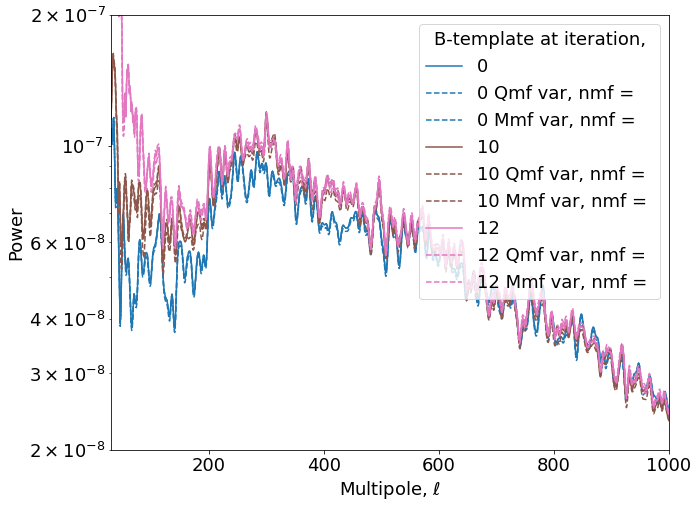

In [6]:
fig = plt.figure(figsize=(10,8))
shift = 0
cmap = matplotlib.cm.get_cmap('tab20')
rgba = cmap(np.arange(0,1,1/20))
cidx = 0
for nmfi, nmf in enumerate(nmfs):
    for speci, (btc, btc_Qvar, btc_Mvar) in enumerate(zip(btcs[nmfi], btcs_Qvar[nmfi], btcs_Mvar[nmfi])):
        if speci in [0,10,12]:
            plt.plot(btc, label=speci, color=rgba[speci])
            plt.plot(btc_Qvar, label=str(speci)+' Qmf var, nmf = {}'.format(nmf), color=rgba[cidx+speci], ls='--')
            plt.plot(btc_Mvar, label=str(speci)+' Mmf var, nmf = {}'.format(nmf), color=rgba[cidx+speci], ls='--')
            plt.plot(hp.alm2cl(plms[speci]), color=rgba[speci], lw=3, ls = '--')
    cidx+=1
plt.legend(title='B-template at iteration,')
# plt.xscale('log')
plt.yscale('log')
plt.xlim(30,1000)
plt.ylim(2e-8,2e-7)
plt.xlabel('Multipole, $\ell$')
plt.ylabel('Power')
sims_str = 'cmbs4/08b/caterinaILC_May12'
plt.savefig('/global/homes/s/sebibel/plots/'+sims_str+'/Cl_mf_mfvar.pdf', bbox_inches='tight')

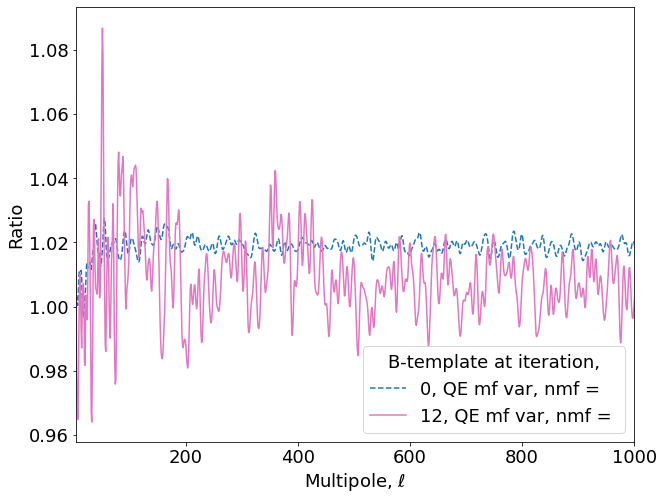

In [9]:

fig = plt.figure(figsize=(10,8))
shift = 0
cmap = matplotlib.cm.get_cmap('tab20')
rgba = cmap(np.arange(0,1,1/20))
edges = cmbs4_edges
edges_center = (edges[1:]+edges[:-1])
fmts = ['1', 'x', 'o', 'o', '1', 'x', 'o','1', 'x', 'o','x', 'x', 'o', 'x', 'x', 'D']
ls = {0:'--', 12: '-'}
for nmfi, nmf in enumerate(nmfs):
    if nmfi == 0:
        for speci, (btc, btc_Qvar, btc_Mvar) in enumerate(zip(btcs[nmfi], btcs_Qvar[nmfi], btcs_Mvar[nmfi])):
            if speci in [0,12]:
                # if speci == 0:
                #     shift = 0.
                # else:
                #     shift = 0.02
                plt.plot(btc/btc_Qvar, color=rgba[speci], label=str(speci)+", QE mf var, nmf = {}".format(nmf), ls=ls[speci])
                # plt.plot(btc/btc_Mvar, color=rgba[2], label=str(speci)+", $\phi^{MAP}-MF^{MAP}$"+" nmf = {}".format(nmf), ls=ls[speci])
                # mean, std = np.array([np.mean((btc/btc_Qvar)[(n-1)*50:n*50]) for n in range(20)]), np.array([np.std((btc/btc_Qvar)[(n-1)*50:n*50]) for n in range(20)])
                # plt.errorbar(np.arange(0,1000,1000/20)-speci, mean, yerr=std, label=str(speci)+", QE mf variation", color=rgba[0], lw=3, ls='', capsize=5, ms=20, fmt=fmts[speci])
                # mean, std = np.array([np.mean((btc/btc_Mvar)[(n-1)*50:n*50]) for n in range(20)]), np.array([np.std((btc/btc_Mvar)[(n-1)*50:n*50]) for n in range(20)])
                # plt.errorbar(np.arange(0,1000,1000/20)-speci, mean, yerr=std, label=str(speci)+", $\phi^{MAP}-MF^{MAP}$", color=rgba[2], lw=3, ls='', capsize=5, ms=2, fmt=fmts[speci])
plt.legend(title='B-template at iteration,',loc='lower right')
plt.xlim(4,1000)
# plt.ylim(0.98,1.03)
plt.xlabel('Multipole, $\ell$')
plt.ylabel('Ratio')
sims_str = 'cmbs4/08b/caterinaILC_May12'
plt.savefig('/global/homes/s/sebibel/plots/'+sims_str+'/Cl_mf_mfvar_ratio.pdf', bbox_inches='tight')

In [ ]:
dlmmod_map = hp.alm2map(dlmmod, nside=2048)
mf1_map = hp.alm2map(mf1, nside=2048)
plm12_map = hp.alm2map(plm12[0], nside=2048)
mf1_map = hp.alm2map(mf1, nside=2048)
mf2_map = hp.alm2map(mf2, nside=2048)
hp.mollview(mf1_map, norm='hist')
hp.mollview(mf2_map, norm='hist')
hp.mollview(mf2_map-mf1_map, norm='hist')
mf1_cl = hp.alm2cl(mf1)
mf2_cl = hp.alm2cl(mf2)
mf2_clX = hp.alm2cl(mf1, alms2=mf2)
# plt.plot(mf1_cl/mf2_cl)
plt.plot(mf1_cl)
plt.plot(mf2_cl)
plt.plot(mf2_clX)
# plt.yscale('log')
# plt.ylim(1e16,1e18)
plt.plot(mf2_clX**2/(mf1_cl*mf2_cl), label='Meanfield Correlation')
plt.legend()
plt.xlabel('Multipole')
plt.ylabel('$ \dfrac{C^{mf00,mf07}}{C^{mf00,mf00}C^{mf07,mf07}}$')

# Meanfields

In [93]:
mf12 = np.load('/global/cscratch1/sd/sebibel/cmbs4/08b_07_OBD_MF100_example/mf/mf_it012.npy')
mf0 = np.load('/global/cscratch1/sd/sebibel/cmbs4/08b_07_OBD_MF100_example/mf/mf_it000.npy')
plms = rec.load_plms('/global/cscratch1/sd/sebibel/cmbs4/08b_07_OBD_MF100_example/p_p_sim0000/', [12])
# btemp1_map = hp.alm2map(btemp1, nside=2048)
# btempmod_map = hp.alm2map(btemp_mod, nside=2048)
# btemp1_cl = hp.alm2cl(btemp1)
# btempmod_cl = hp.alm2cl(btemp_mod)
# plt.plot(btemp1_cl/btempmod_cl)
# plt.hlines(1,0,1000)
# plt.plot()
# plt.yscale('log')

(10, 1000)

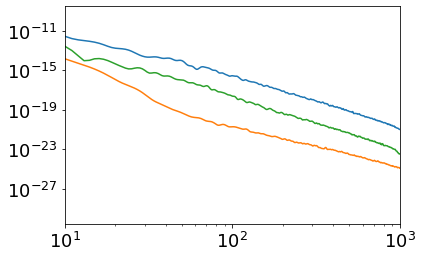

In [103]:
plt.plot(hp.alm2cl(plms[-1]))

plt.plot(hp.alm2cl(mf0))
plt.plot(hp.alm2cl(mf12))

plt.xscale('log')
plt.yscale('log')
plt.xlim(10,1000)

(0.0, 0.02)

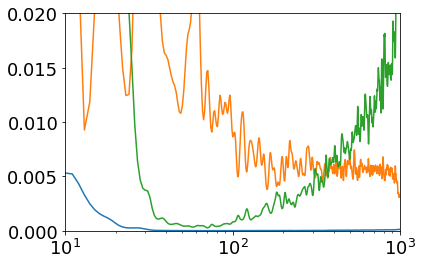

In [112]:
plt.plot(hp.alm2cl(mf0)/hp.alm2cl(plms[-1]))
plt.plot(hp.alm2cl(mf12)/hp.alm2cl(plms[-1]))
plt.plot(hp.alm2cl(mf0)/hp.alm2cl(mf12))
# plt.plot()
plt.xscale('log')
# plt.yscale('log')
plt.xlim(10,1000)
plt.ylim(0,0.02)

In [156]:
mf12_07 = np.load('/global/cscratch1/sd/sebibel/cmbs4/08b_07_OBD_MF100_example/mf/mf_it012.npy')
mf12_00 = np.load('/global/cscratch1/sd/sebibel/cmbs4/08b_00_OBD_MF100_example/mf/mf_it012.npy')

mf00_07 = np.load('/global/cscratch1/sd/sebibel/cmbs4/08b_07_OBD_MF100_example/mf/mf_it000.npy')
mf00_00 = np.load('/global/cscratch1/sd/sebibel/cmbs4/08b_00_OBD_MF100_example/mf/mf_it000.npy')

plms_07 = rec.load_plms('/global/cscratch1/sd/sebibel/cmbs4/08b_07_OBD_MF100_example/p_p_sim0000/', [0,12])
plms_00 = rec.load_plms('/global/cscratch1/sd/sebibel/cmbs4/08b_00_OBD_MF100_example/p_p_sim0000/', [0,12])

(10, 1000)

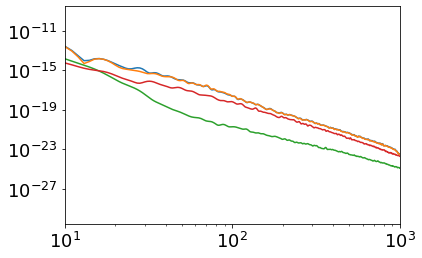

In [121]:
plt.plot(hp.alm2cl(mf12_07))
plt.plot(hp.alm2cl(mf12_00))

plt.plot(hp.alm2cl(mf00_07))
plt.plot(hp.alm2cl(mf00_00))

plt.xscale('log')
plt.yscale('log')
plt.xlim(10,1000)

(0.8, 1.2)

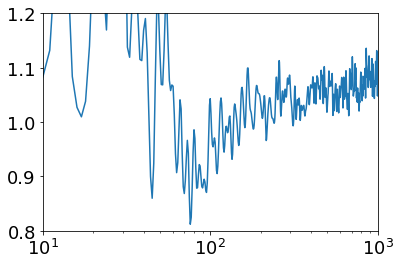

In [119]:
plt.plot(hp.alm2cl(mf12_07)/hp.alm2cl(mf12_00))

plt.xscale('log')
# plt.yscale('log')
plt.xlim(10,1000)
plt.ylim(0.8,1.2)

(0.001, 0.22)

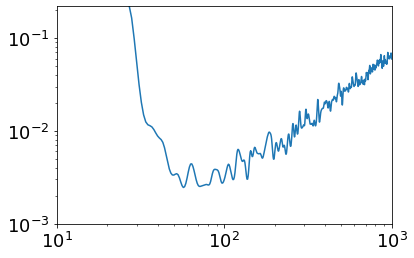

In [130]:
plt.plot(hp.alm2cl(mf00_07)/hp.alm2cl(mf00_00))

plt.xscale('log')
plt.yscale('log')
plt.xlim(10,1000)
plt.ylim(0.001,.22)

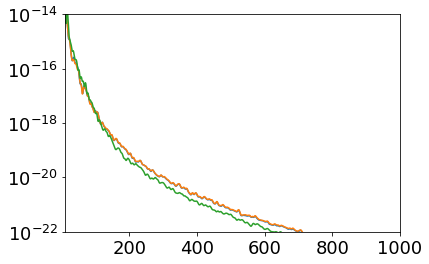

In [163]:
# plt.plot(((hp.alm2cl(mf12_07-plms[0])/100)*100/99)/hp.alm2cl(mf12_07))
plt.plot(((hp.alm2cl(mf12_00-plms_00[1])/100)*100/99))
plt.plot(((hp.alm2cl(mf12_07-plms_07[1])/100)*100/99))
plt.plot(hp.alm2cl(mf12_00))
plt.ylim(1e-22,1e-14)
plt.xlim(10,1000)
plt.yscale('log')

(10.0, 1000.0)

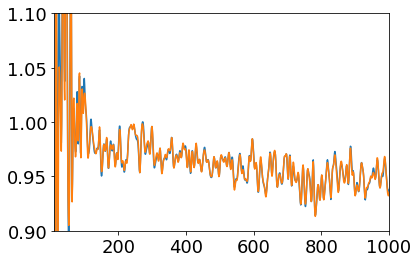

In [165]:
plt.plot(((hp.alm2cl(mf12_00-plms_00[1])/100)*100/99)/((hp.alm2cl(mf12_07-plms_07[1])/100)*100/99))
plt.plot(((hp.alm2cl(mf12_00-plms_00[1])/100)*100/99)/((hp.alm2cl(mf12_00-plms_07[1])/100)*100/99))
plt.ylim(0.9,1.1)
plt.xlim(10,1000)
# plt.yscale('log')

In [ ]:

iterations = np.arange(0,12+1)
_simidx = 2
btemps = np.array([np.load("/global/cscratch1/sd/sebibel/cmbs4/08b_00_OBD_MF100_example/p_p_sim%04d/wflms/btempl_p%03d_e%03d_lmax1024.npy"%(_simidx, it, it)) for it in iterations])
btemps_mod = np.array([np.load("/global/cscratch1/sd/sebibel/cmbs4/08b_00_OBD_MF100_example/p_p_sim%04d/wflms/btempl_p%03d_e%03d_lmax1024_dlmmod.npy"%(_simidx, it, it)) for it in iterations])
btemp_diff_map = np.array([hp.alm2map(ph.bandpass_alms(btemp-btemp_mod,200,1000), nside=2048) for btemp, btemp_mod in zip(btemps,btemps_mod)])
btemp_maps = np.array([hp.alm2map(btemp, nside=2048) for btemp in btemps])
btemp_mod_maps = np.array([hp.alm2map(btemp, nside=2048) for btemp in btemps_mod])


for i, btemp_map in enumerate(btemp_maps):
    hp.mollview(btemp_map, norm='hist')
    # hp.mollview(btemp_map-btemp_mod_maps[i])
for i, btemp_map in enumerate(btemp_maps):
    # hp.mollview(btemp_map, norm='hist')
    hp.mollview(btemp_map-btemp_mod_maps[i], norm='hist')
for i, (btemp_diff, btemp_map, btemp_mod)  in enumerate(zip(btemp_diff_map, btemp_maps, btemp_mod_maps)):
    if i == 2:
    # hp.mollview(btemp_map, norm='hist')
        hp.cartview(btemp_diff, lonra=[0,70], latra=[-70,-30], norm='hist', cmap='PuOr')
        hp.cartview(btemp_map, lonra=[0,70], latra=[-70,-30], norm='hist', cmap='PuOr')
        hp.cartview(btemp_mod, lonra=[0,70], latra=[-70,-30], norm='hist', cmap='PuOr')
btemp_cl = np.array([hp.alm2cl(mf) for mf in btemps])
btemp_mod_cl = np.array([hp.alm2cl(mf) for mf in btemps_mod])
fig = plt.figure(figsize=(10,8))

for speci, spec in enumerate(btemp_cl):
    if speci in [0,10,12]:
        plt.plot(spec/btemp_mod_cl[speci], label=speci, lw=2, color=rgba[speci])
        # plt.plot(, lw=2, color=rgba[speci], ls='--')
plt.legend(title='B template at iteration,')
plt.xscale('log')
# plt.yscale('log')
plt.xlim(100,1000)
# plt.ylim(3e-8,1.2e-7)
plt.ylim(0.97,1.05)
plt.xlabel('Multipole, $\ell$')
plt.ylabel('Ratio')